## Linear layer

The dimensionality of the linear layer doesn't currently fit with what is being output from the scattering layers. Fix this so we can test a scattering+linear layer

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import time, sys, os
import matplotlib.pyplot as plt

# my modules
from sn_camels.models.models_factory import baseModelFactory, topModelFactory
from sn_camels.models.sn_hybrid_models import sn_HybridModel
from sn_camels.camels.camels_dataset import *

/home/chris/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


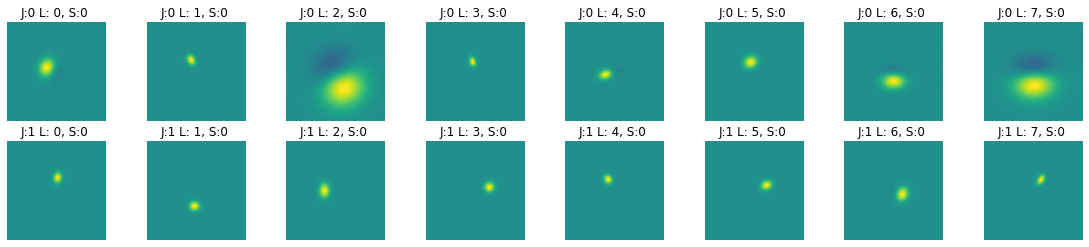

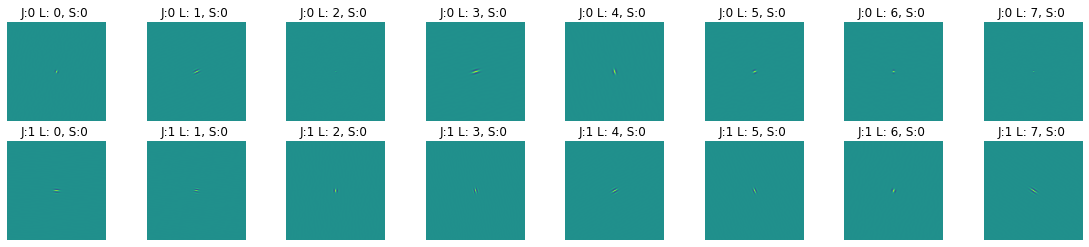

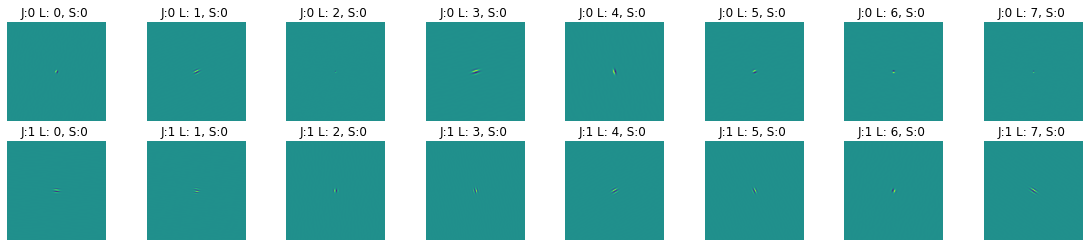

In [4]:
scatteringBase = baseModelFactory( #creat scattering base model
    architecture='scattering',
    J=2,
    N=256,
    M=256,
    second_order=True,
    initialization="Random",
    seed=123,
    learnable=False,
    lr_orientation=0.1,
    lr_scattering=0.1,
    filter_video=False,
    device="cpu",
    use_cuda=False
)

In [5]:
top = topModelFactory( #create cnn, mlp, linearlayer, or other
    base=scatteringBase,
    architecture="cnn",
    num_classes=12, 
    width=8, 
    use_cuda=False
)


In [8]:
hybridModel = sn_HybridModel(scatteringBase=scatteringBase, top=top, use_cuda=False) #creat hybrid model

In [9]:
## CPU only due to crashes
print('CUDA Not Available')
device = torch.device('cpu')
cudnn.benchmark = True      #May train faster but cost more memory

CUDA Not Available


In [16]:
## camels path
camels_path=os.environ['CAMELS_PATH']

# data parameters
fmaps      = ['maps_Mcdm.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = camels_path+"/params_IllustrisTNG.txt"
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 1   #number of maps per simulation

# training parameters
channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

# optimizer parameters
beta1 = 0.5
beta2 = 0.999

# hyperparameters
batch_size = 1
lr         = 1e-3
wd         = 0.0005  #value of weight decay
dr         = 0.2    #dropout value for fully connected layers
hidden     = 5      #this determines the number of channels in the CNNs; integer larger than 1
epochs     = 10    #number of epochs to train the network

# output files names
floss  = 'loss.txt'   #file with the training and validation losses for each epoch
fmodel = 'weights.pt' #file containing the weights of the best-model

In [17]:
fmaps2 = camels_path+"/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy"
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

Shape of the maps: (15000, 256, 256)


In [18]:
# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):  
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_Mcdm.npy', maps)
del maps

Selected 1000 maps out of 15000


In [19]:
# This routine returns the data loader need to train the network
def create_dataset_multifield(mode, seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                              rot_flip_in_mem=True, shuffle=True, verbose=False):

    # whether rotations and flippings are kept in memory
    if rot_flip_in_mem:
        data_set = make_dataset_multifield(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)
    else:
        data_set = make_dataset_multifield2(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)

    data_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle)
    return data_loader


# get training set
print('\nPreparing training set')
train_loader = create_dataset_multifield('train', seed, fmaps, fparams, batch_size, splits, fmaps_norm, 
                                         rot_flip_in_mem=rot_flip_in_mem, verbose=True)

# get validation set
print('\nPreparing validation set')
valid_loader = create_dataset_multifield('valid', seed, fmaps, fparams, batch_size, splits, fmaps_norm, 
                                         rot_flip_in_mem=True,  verbose=True)       


Preparing training set
Found 1 channels
Reading data...
3.859e+09 < F(all|orig) < 1.963e+15
9.586 < F(all|resc)  < 15.293
-2.759 < F(all|norm) < 8.501

Preparing validation set
Found 1 channels
Reading data...
3.859e+09 < F(all|orig) < 1.963e+15
9.586 < F(all|resc)  < 15.293
-2.759 < F(all|norm) < 8.501
Channel 0 contains 400 maps
-2.497 < F < 7.859



In [20]:
## Single data batch
x, y=next(iter(train_loader))

In [21]:
x.shape

torch.Size([1, 1, 256, 256])

In [22]:
hybridModel.forward(x)

tensor([[-0.2526,  0.1280, -1.1243, -0.7661, -0.3348, -1.0805,  1.1022, -0.3653,
         -0.6054, -0.4601, -0.0661, -0.3011]], grad_fn=<AddmmBackward0>)